In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def load_data(data_path):
    # data_path = "./datasets/37.5Hz11kN/Bearing2_4/"
    file_list = os.listdir(data_path)

    file_list = sorted(file_list, key=lambda x: int(x.split('.')[0]))

    df = pd.DataFrame()
    for f in tqdm(file_list, desc=f"Load Dataset: {data_path}"):
        temp = pd.read_csv(data_path + f"\\{f}")
        df = pd.concat([df, temp], axis=0)
    df.reset_index(drop=True, inplace=True)
    return df

# df = load_data(f"{data_path}/Bearing1_4/")

class BearingDataset(Dataset):
    def __init__(self, file_name):
        df = load_data(file_name)
        scaler = StandardScaler()
        self.data = scaler.fit_transform(df.iloc[:, :2])  # Only use first 2 columns
        
        # Create RUL column
        self.rul = np.linspace(1, 0, len(self.data))
        
        # Reshape data into sequences of length 128
        self.sequences = []
        self.rul_sequences = []
        for i in range(0, len(self.data) - 127, 128):
            self.sequences.append(self.data[i:i+128])
            self.rul_sequences.append(self.rul[i:i+128])
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx]), torch.FloatTensor(self.rul_sequences[idx])

data_path = "datasets/35Hz12kN"

train_datasets = [BearingDataset(f"{data_path}/Bearing1_{i}/") for i in range(1, 4)]
train_dataset = torch.utils.data.ConcatDataset(train_datasets)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = BearingDataset(f"{data_path}/Bearing1_4/")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Load Dataset: datasets/35Hz12kN/Bearing1_4/: 100%|██████████| 122/122 [00:02<00:00, 44.92it/s]


In [9]:
# VAE-GAN model
class VAE_GAN(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_GAN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim * 128, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim * 128),
            nn.Tanh()
        )
        self.discriminator = nn.Sequential(
            nn.Linear(input_dim * 128, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(x.size(0), -1)
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [17]:

# BLSTM model
class BLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [22]:

# Training functions
def train_vae_gan(model, optimizer_vae, optimizer_disc, data_loader, num_epochs):
    loss_log = []
    
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for x, _ in tqdm(data_loader, desc=f"VAE-GAN: {epoch}/{num_epochs}"):
            x = x.to(device)
            batch_size = x.size(0)
            
            # Train Discriminator
            optimizer_disc.zero_grad()
            
            recon_x, mu, logvar = model(x)
            real_output = model.discriminator(x.view(batch_size, -1))
            fake_output = model.discriminator(recon_x.detach())
            
            d_loss_real = torch.mean(torch.log(real_output + 1e-8))
            d_loss_fake = torch.mean(torch.log(1 - fake_output + 1e-8))
            d_loss = -0.5 * (d_loss_real + d_loss_fake)
            
            d_loss.backward()
            optimizer_disc.step()
            
            # Train VAE/Generator
            optimizer_vae.zero_grad()
            
            recon_x, mu, logvar = model(x)
            fake_output = model.discriminator(recon_x)
            
            recon_loss = nn.MSELoss()(recon_x, x.view(batch_size, -1))
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            g_loss = torch.mean(torch.log(1 - fake_output + 1e-8))
            
            vae_loss = recon_loss + 0.1 * kl_div + 0.1 * g_loss
            
            vae_loss.backward()
            optimizer_vae.step()
            
            total_loss += (d_loss.item() + vae_loss.item())
        
        loss = total_loss/len(data_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")
        loss_log.append(loss)

    return loss_log


In [23]:
def train_blstm(model, optimizer, criterion, data_loader, num_epochs):
    loss_log = []

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for x, y in tqdm(data_loader, desc=f"BLSTM: {epoch}/{num_epochs}"):
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        loss = total_loss/len(data_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")
        loss_log.append(loss)

    return loss_log

In [25]:
# Initialize models
input_dim = 2
hidden_dim = 32
latent_dim = 16

vae_gan = VAE_GAN(input_dim, hidden_dim, latent_dim).to(device)
optimizer_vae = optim.Adam(list(vae_gan.encoder.parameters()) + list(vae_gan.decoder.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_disc = optim.Adam(vae_gan.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Train models
vae_loss = train_vae_gan(vae_gan, optimizer_vae, optimizer_disc, train_loader, num_epochs=10)

VAE-GAN: 0/10: 100%|██████████| 3536/3536 [00:18<00:00, 195.29it/s]


Epoch [1/10], Loss: 1.7440


VAE-GAN: 1/10: 100%|██████████| 3536/3536 [00:17<00:00, 196.77it/s]


Epoch [2/10], Loss: 1.3930


VAE-GAN: 2/10: 100%|██████████| 3536/3536 [00:18<00:00, 195.72it/s]


Epoch [3/10], Loss: 1.3397


VAE-GAN: 3/10: 100%|██████████| 3536/3536 [00:18<00:00, 191.70it/s]


Epoch [4/10], Loss: 1.4279


VAE-GAN: 4/10: 100%|██████████| 3536/3536 [00:18<00:00, 190.67it/s]


Epoch [5/10], Loss: 1.4313


VAE-GAN: 5/10: 100%|██████████| 3536/3536 [00:18<00:00, 192.98it/s]


Epoch [6/10], Loss: 1.4372


VAE-GAN: 6/10: 100%|██████████| 3536/3536 [00:18<00:00, 187.23it/s]


Epoch [7/10], Loss: 1.4414


VAE-GAN: 7/10: 100%|██████████| 3536/3536 [00:18<00:00, 190.45it/s]


Epoch [8/10], Loss: 1.4399


VAE-GAN: 8/10: 100%|██████████| 3536/3536 [00:18<00:00, 189.00it/s]


Epoch [9/10], Loss: 1.4423


VAE-GAN: 9/10: 100%|██████████| 3536/3536 [00:17<00:00, 196.62it/s]

Epoch [10/10], Loss: 1.4372


In [26]:
# Initialize models
input_dim = 2
hidden_dim = 32
latent_dim = 16

blstm = BLSTM(input_dim, hidden_dim, num_layers=4, output_size=1).to(device)
blstm_optimizer = optim.Adam(blstm.parameters())
blstm_criterion = nn.MSELoss()

# Train models
blstm_loss = train_blstm(blstm, blstm_optimizer, blstm_criterion, train_loader, num_epochs=20)

BLSTM: 0/20: 100%|██████████| 3536/3536 [00:14<00:00, 241.55it/s]


Epoch [1/20], Loss: 0.0163


BLSTM: 1/20: 100%|██████████| 3536/3536 [00:14<00:00, 244.76it/s]


Epoch [2/20], Loss: 0.0103


BLSTM: 2/20: 100%|██████████| 3536/3536 [00:13<00:00, 252.58it/s]


Epoch [3/20], Loss: 0.0107


BLSTM: 3/20: 100%|██████████| 3536/3536 [00:14<00:00, 247.46it/s]


Epoch [4/20], Loss: 0.0104


BLSTM: 4/20: 100%|██████████| 3536/3536 [00:14<00:00, 251.01it/s]


Epoch [5/20], Loss: 0.0092


BLSTM: 5/20: 100%|██████████| 3536/3536 [00:13<00:00, 252.75it/s]


Epoch [6/20], Loss: 0.0083


BLSTM: 6/20: 100%|██████████| 3536/3536 [00:13<00:00, 254.53it/s]


Epoch [7/20], Loss: 0.0075


BLSTM: 7/20: 100%|██████████| 3536/3536 [00:14<00:00, 246.98it/s]


Epoch [8/20], Loss: 0.0072


BLSTM: 8/20: 100%|██████████| 3536/3536 [00:14<00:00, 249.68it/s]


Epoch [9/20], Loss: 0.0068


BLSTM: 9/20: 100%|██████████| 3536/3536 [00:13<00:00, 255.38it/s]


Epoch [10/20], Loss: 0.0067


BLSTM: 10/20: 100%|██████████| 3536/3536 [00:14<00:00, 246.89it/s]


Epoch [11/20], Loss: 0.0064


BLSTM: 11/20: 100%|██████████| 3536/3536 [00:13<00:00, 257.77it/s]


Epoch [12/20], Loss: 0.0061


BLSTM: 12/20: 100%|██████████| 3536/3536 [00:14<00:00, 245.55it/s]


Epoch [13/20], Loss: 0.0059


BLSTM: 13/20: 100%|██████████| 3536/3536 [00:14<00:00, 247.30it/s]


Epoch [14/20], Loss: 0.0057


BLSTM: 14/20: 100%|██████████| 3536/3536 [00:14<00:00, 246.62it/s]


Epoch [15/20], Loss: 0.0056


BLSTM: 15/20: 100%|██████████| 3536/3536 [00:14<00:00, 251.09it/s]


Epoch [16/20], Loss: 0.0054


BLSTM: 16/20: 100%|██████████| 3536/3536 [00:15<00:00, 234.15it/s]


Epoch [17/20], Loss: 0.0053


BLSTM: 17/20: 100%|██████████| 3536/3536 [00:14<00:00, 238.31it/s]


Epoch [18/20], Loss: 0.0052


BLSTM: 18/20: 100%|██████████| 3536/3536 [00:14<00:00, 240.71it/s]


Epoch [19/20], Loss: 0.0051


BLSTM: 19/20: 100%|██████████| 3536/3536 [00:14<00:00, 247.89it/s]

Epoch [20/20], Loss: 0.0050


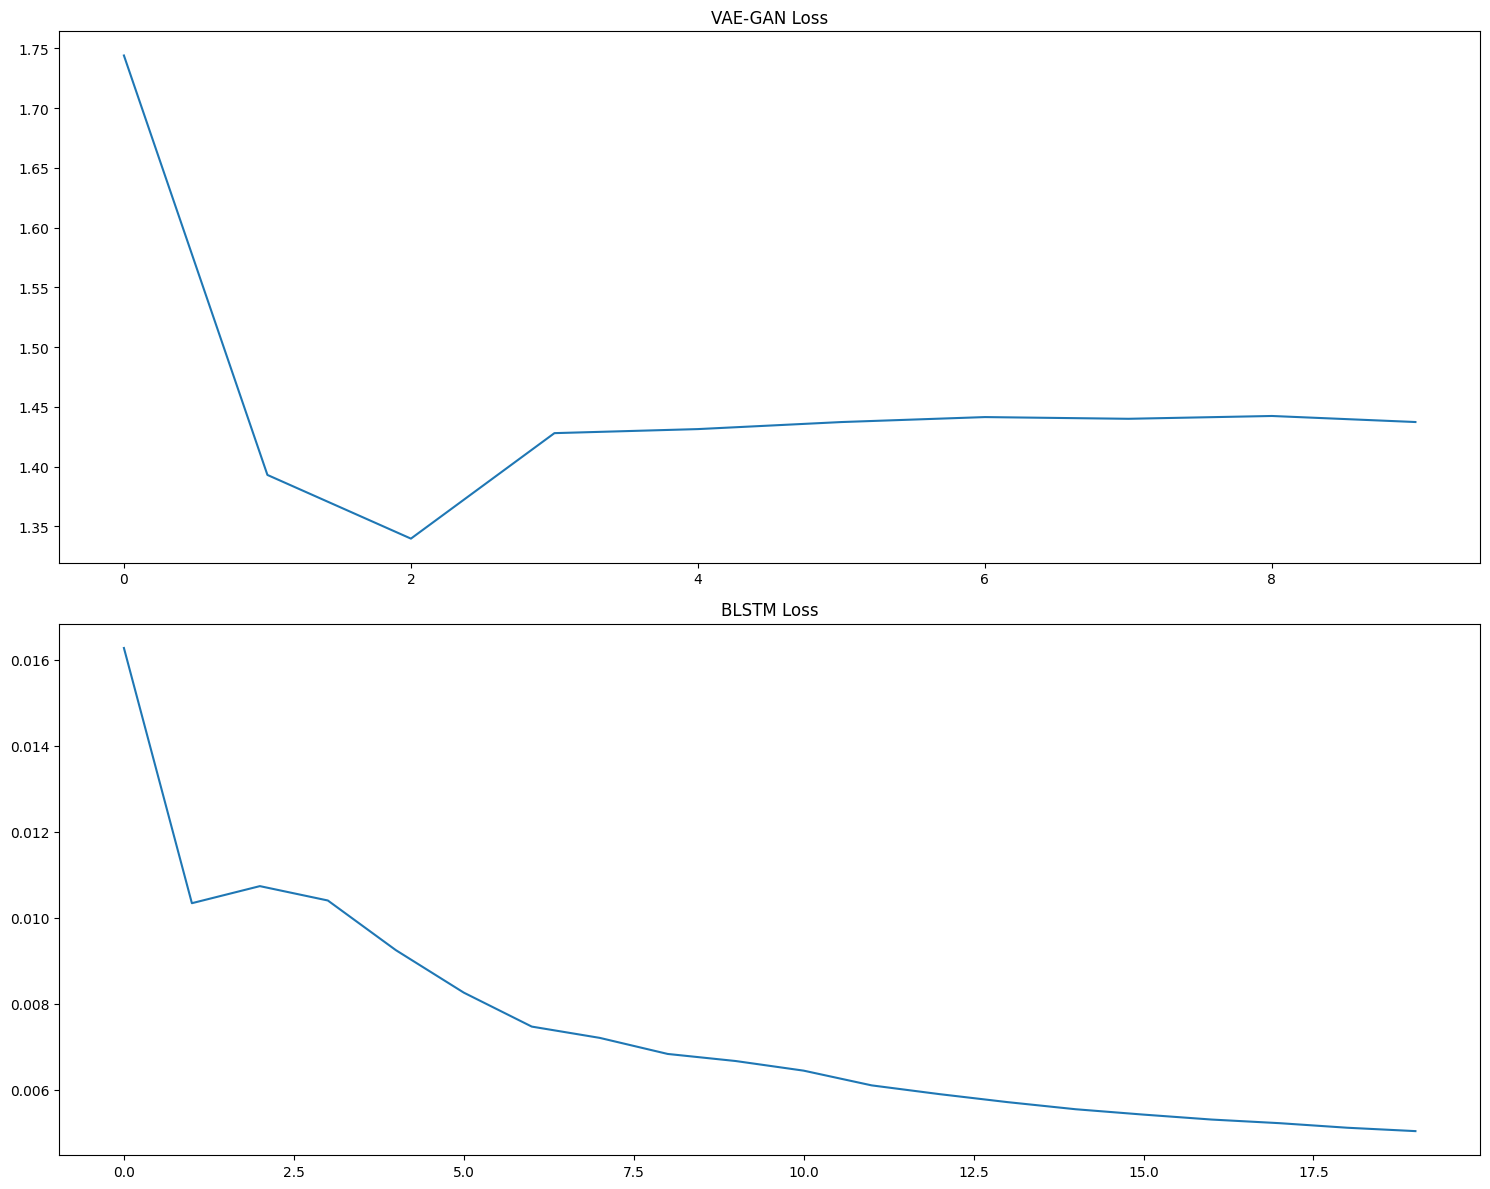

In [27]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 1, 1)
plt.plot(vae_loss, label="VAE-GAN Loss")
plt.title("VAE-GAN Loss")

plt.subplot(2, 1, 2)
plt.plot(blstm_loss, label="BLSTM Loss")
plt.title("BLSTM Loss")

plt.tight_layout()
plt.show()

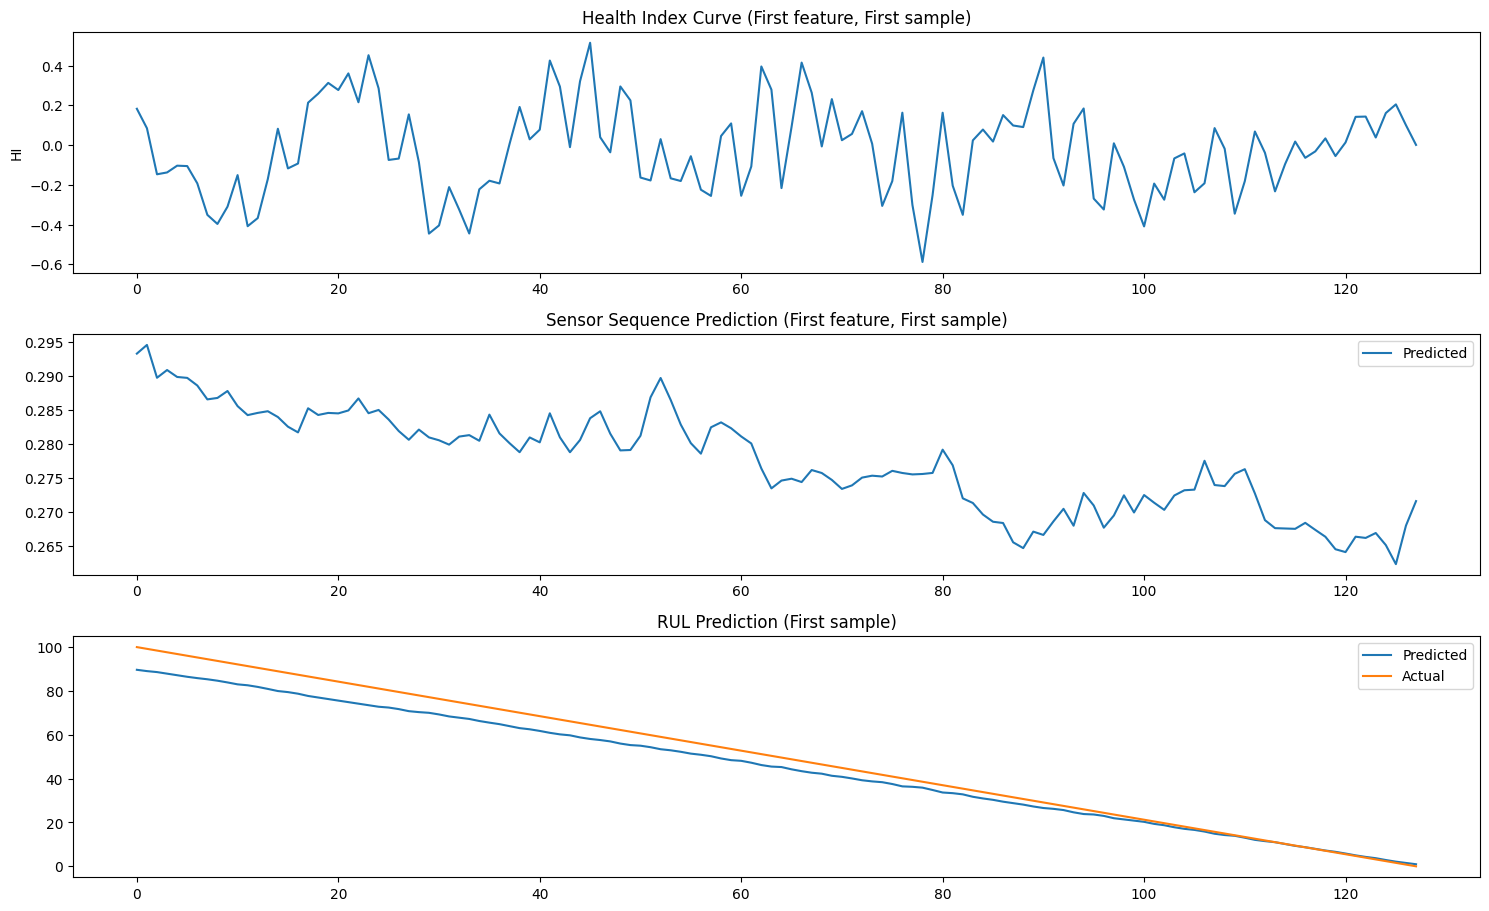

In [32]:
def predict_rul(vae_gan, blstm, data_loader):
    vae_gan.eval()
    blstm.eval()
    hi_curves = []
    predicted_seqs = []
    actual_ruls = []
    
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            
            # Generate HI curve
            recon_x, _, _ = vae_gan(x)
            hi_curve = recon_x.view(x.size()).cpu().numpy()
            hi_curves.append(hi_curve)
            
            # Predict sensor sequence
            predicted_seq = blstm(x).cpu().numpy()
            predicted_seqs.append(predicted_seq)
            
            actual_ruls.append(y.cpu().numpy())
    
    hi_curves = np.concatenate(hi_curves)
    predicted_seqs = np.concatenate(predicted_seqs)
    actual_ruls = np.concatenate(actual_ruls)
    
    # Predict RUL using both HI curves and predicted sensor sequences
    predicted_ruls = []
    threshold = 0.23  # As mentioned in the paper
    
    for i in range(len(hi_curves)):
        hi_curve = hi_curves[i]
        predicted_seq = predicted_seqs[i]
        
        # Find the cycle where HI drops below the threshold
        failure_point = np.argmax(hi_curve[:, 0] < threshold)
        if failure_point == 0:  # If HI never drops below threshold
            failure_point = len(hi_curve)
        
        # Calculate RUL based on HI curve
        rul_hi = failure_point - np.arange(len(hi_curve))
        rul_hi[rul_hi < 0] = 0
        
        # Use predicted sensor sequence to refine RUL prediction
        # Here we assume that larger values in predicted_seq indicate higher degradation
        degradation_rate = np.mean(predicted_seq[:failure_point])
        remaining_cycles = (threshold - hi_curve[:, 0]) / degradation_rate
        rul_refined = np.clip(remaining_cycles, 0, None)
        
        # Combine RUL predictions (you can adjust the weights)
        rul_combined = 0.7 * rul_hi + 0.3 * rul_refined
        
        predicted_ruls.append(rul_combined)
    
    predicted_ruls = np.array(predicted_ruls)
    
    return hi_curves, predicted_seqs, predicted_ruls, actual_ruls

# Predict and visualize
hi_curves, predicted_seqs, predicted_ruls, actual_ruls = predict_rul(vae_gan, blstm, test_loader)

actual_ruls = np.linspace(100, 0, len(predicted_ruls[0]))

# Visualize results
plt.figure(figsize=(15, 12))

plt.subplot(4, 1, 1)
plt.plot(hi_curves[0, :, 0])  # Plot first feature of HI curve for the first sample
plt.title("Health Index Curve (First feature, First sample)")
plt.ylabel("HI")

plt.subplot(4, 1, 2)
plt.plot(predicted_seqs[0, :, 0], label="Predicted")
plt.title("Sensor Sequence Prediction (First feature, First sample)")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(predicted_ruls[0], label="Predicted")
plt.plot(actual_ruls, label="Actual")
plt.title("RUL Prediction (First sample)")
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
torch.save(vae_gan, 'vae_gan_state_dict.pt')
torch.save(blstm, 'blstm_state_dict.pt')